In [9]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

#####
def mag_field_r_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    return B_r_stddev**2

# tangential
def mag_field_t_variance(filename,groupname):
    B_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]  
    return B_theta_stddev**2+B_phi_stddev**2

def mag_field_sq_mean(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))

def mag_field_magnitude(filename,groupname):
    return mag_field_variance**(1/2)
#####

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

NameError: name 'line_11_no_mag' is not defined

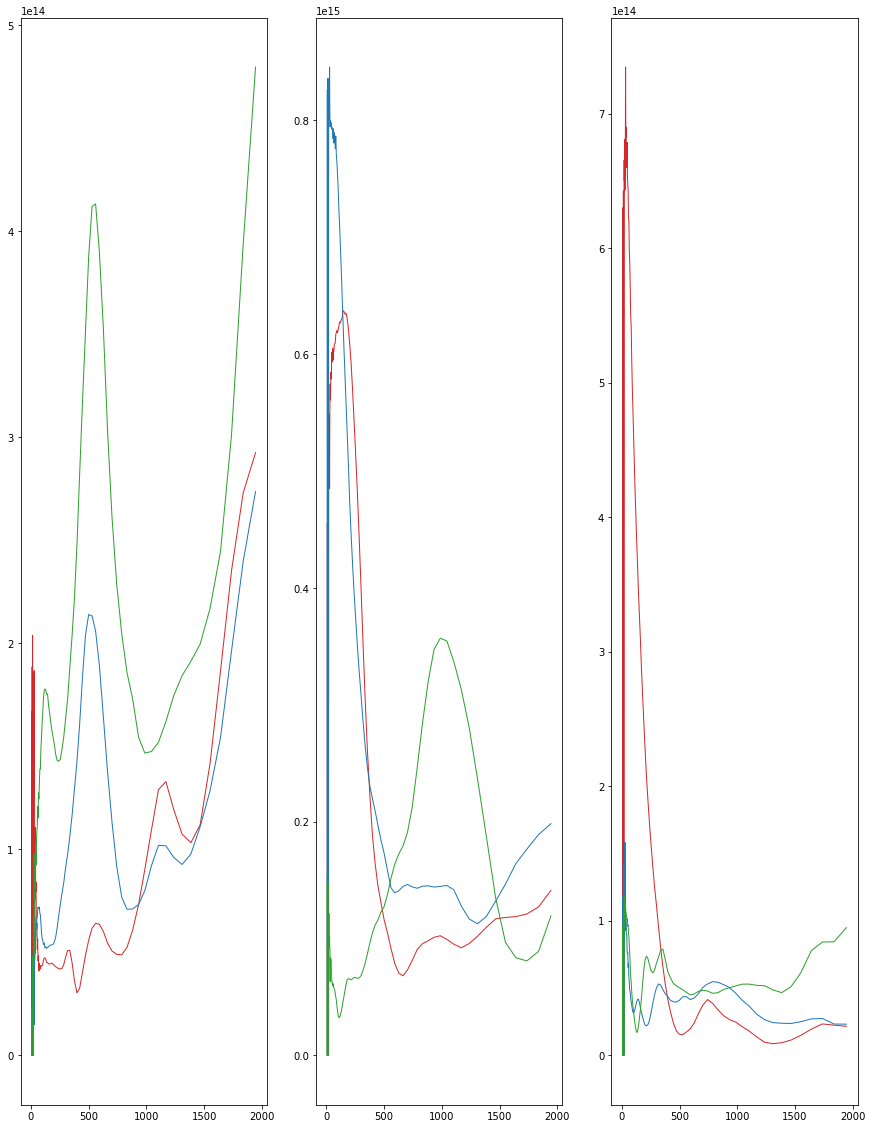

In [2]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

# xlim1=2e1
# xlim2=2e3
# ylim1=5e-29
# ylim2=3e-26
# num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

# ax1 = m.plt.subplot(131, aspect=num)
# ax2 = m.plt.subplot(132, aspect=num)
# ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

ax1 = m.plt.subplot(131)
ax2 = m.plt.subplot(132)
ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
# line_11_no_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_12_no_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_13_no_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_21_no_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_22_no_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_23_no_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_31_no_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_32_no_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_33_no_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(mag_field_r_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
#     plot_ax.set_xlim(xlim1,xlim2)
#     plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

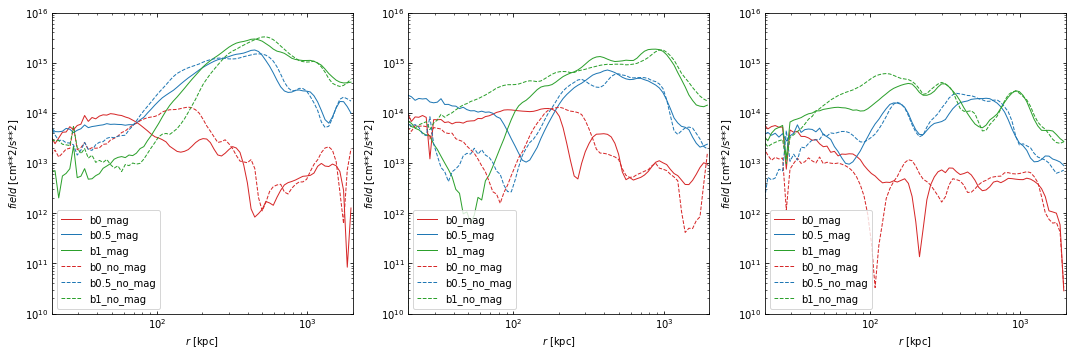

In [6]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e10
ylim2=1e16
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_12_no_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_13_no_mag, =ax1.plot(radius, velocity_mean_sq(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_21_no_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_22_no_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_23_no_mag, =ax2.plot(radius, velocity_mean_sq(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
line_31_no_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
line_32_no_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
line_33_no_mag, =ax3.plot(radius, velocity_mean_sq(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

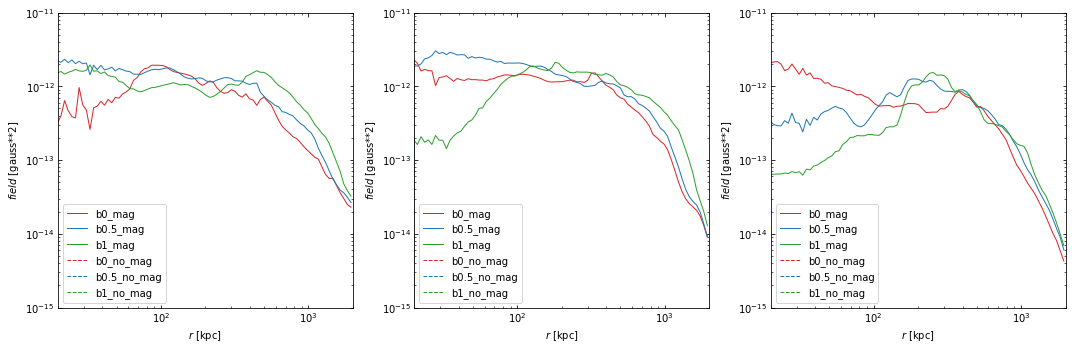

In [17]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-15
ylim2=1e-11
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
# line_11_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_12_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_13_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_21_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_22_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_23_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_31_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_32_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_33_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(mag_field_sq_mean(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

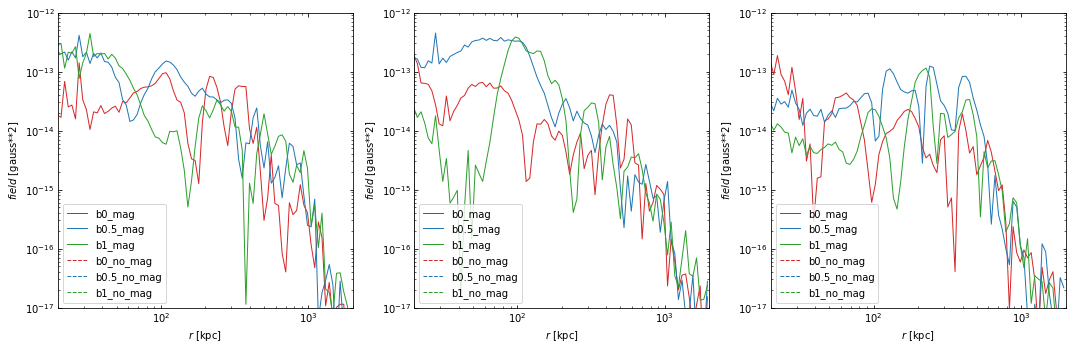

In [18]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-17
ylim2=1e-12
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_12_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_13_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_21_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_22_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_23_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag")
line_31_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag")
line_32_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag")
line_33_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag")

# non-magnetic
# line_11_no_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_12_no_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_13_no_mag, =ax1.plot(radius, mag_field_mean_sq(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_21_no_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_22_no_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_23_no_mag, =ax2.plot(radius, mag_field_mean_sq(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")
# line_31_no_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="b0_no_mag")
# line_32_no_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="b0.5_no_mag")
# line_33_no_mag, =ax3.plot(radius, mag_field_mean_sq(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="b1_no_mag")

ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(mag_field_mean_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

/home/jzuhone/Source/yt/yt/units/yt_array.py:1135: RuntimeWarning: invalid value encountered in true_divide
  return super(YTArray, self).__truediv__(ro)


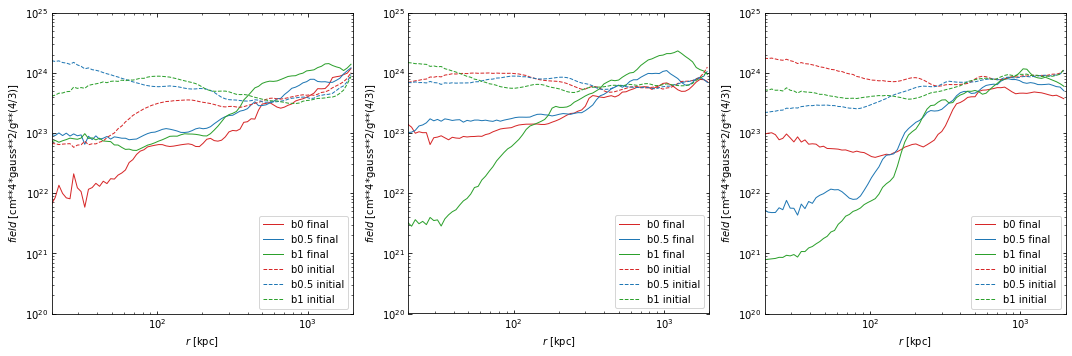

In [28]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e20
ylim2=1e25
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3', lw=1, label="b0 final")
line_12_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0', lw=1, label="b0.5 final")
line_13_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C2', lw=1, label="b1 final")
line_21_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3', lw=1, label="b0 final")
line_22_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0', lw=1, label="b0.5 final")
line_23_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/density(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")**(4/3), 'C2', lw=1, label="b1 final")
line_31_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3', lw=1, label="b0 final")
line_32_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0', lw=1, label="b0.5 final")
line_33_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C2', lw=1, label="b1 final")

# just hacking the name, not actually non magnetic
line_11_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE11_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3--', lw=1, label="b0 initial")
line_12_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE12_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0--', lw=1, label="b0.5 initial")
line_13_no_mag, =ax1.plot(radius, mag_field_sq_mean(SIM_TYPE13_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C2--', lw=1, label="b1 initial")
line_21_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE21_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3--', lw=1, label="b0 initial")
line_22_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE22_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0--', lw=1, label="b0.5 initial")
line_23_no_mag, =ax2.plot(radius, mag_field_sq_mean(SIM_TYPE23_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")**(4/3), 'C2--', lw=1, label="b1 initial")
line_31_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE31_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C3--', lw=1, label="b0 initial")
line_32_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE32_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C0--', lw=1, label="b0.5 initial")
line_33_no_mag, =ax3.plot(radius, mag_field_sq_mean(SIM_TYPE33_mag,"profiles_0000_gpot_afterfix")/density(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")**(4/3), 'C2--', lw=1, label="b1 initial")


ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=4)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=4)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=4)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(mag_field_sq_mean(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/density(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")**(4/3))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()

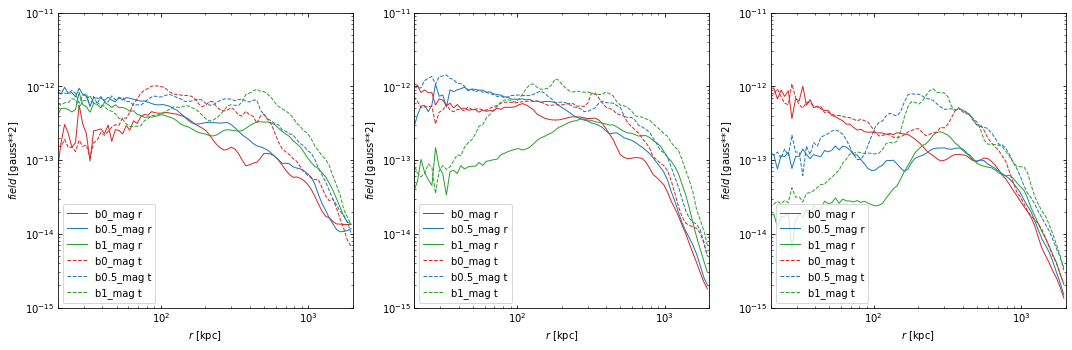

In [14]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

a=00

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-15
ylim2=1e-11
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))

ax1 = m.plt.subplot(131, aspect=num)
ax2 = m.plt.subplot(132, aspect=num)
ax3 = m.plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = m.plt.subplot(131)
# ax2 = m.plt.subplot(132)
# ax3 = m.plt.subplot(133)


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag r")
line_12_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag r")
line_13_mag, =ax1.plot(radius, mag_field_r_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag r")
line_21_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag r")
line_22_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag r")
line_23_mag, =ax2.plot(radius, mag_field_r_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="b1_mag r")
line_31_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="b0_mag r")
line_32_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="b0.5_mag r")
line_33_mag, =ax3.plot(radius, mag_field_r_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="b1_mag r")

# just hacking the names
line_11_no_mag, =ax1.plot(radius, mag_field_t_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C3--', lw=1, label="b0_mag t")
line_12_no_mag, =ax1.plot(radius, mag_field_t_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C0--', lw=1, label="b0.5_mag t")
line_13_no_mag, =ax1.plot(radius, mag_field_t_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C2--', lw=1, label="b1_mag t")
line_21_no_mag, =ax2.plot(radius, mag_field_t_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C3--', lw=1, label="b0_mag t")
line_22_no_mag, =ax2.plot(radius, mag_field_t_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C0--', lw=1, label="b0.5_mag t")
line_23_no_mag, =ax2.plot(radius, mag_field_t_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/2**(0.5), 'C2--', lw=1, label="b1_mag t")
line_31_no_mag, =ax3.plot(radius, mag_field_t_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C3--', lw=1, label="b0_mag t")
line_32_no_mag, =ax3.plot(radius, mag_field_t_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C0--', lw=1, label="b0.5_mag t")
line_33_no_mag, =ax3.plot(radius, mag_field_t_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/2**(0.5), 'C2--', lw=1, label="b1_mag t")


ax1.legend(handles=[line_11_mag,line_12_mag,line_13_mag,line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
#ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.legend(handles=[line_21_mag,line_22_mag,line_23_mag,line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)

#ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.legend(handles=[line_31_mag,line_32_mag,line_33_mag,line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$field$ [%s]" % get_units(mag_field_r_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"))) #% get_units(velocity_mean_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()